<a href="https://colab.research.google.com/github/luishpinto/cm-hydraulic-data-set/blob/master/cnn_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os.path

if not os.path.exists('TS1.txt'):
  !wget -O 'TS1.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS1.txt'

if not os.path.exists('TS2.txt'):
  !wget -O 'TS2.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS2.txt'

if not os.path.exists('TS3.txt'):
  !wget -O 'TS3.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS3.txt'

if not os.path.exists('TS4.txt'):
  !wget -O 'TS4.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS4.txt'

if not os.path.exists('profile.txt'):
  !wget -O 'profile.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/profile.txt'


--2020-02-04 19:03:15--  https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS1.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luishpinto/cm-hydraulic-data-set/master/TS1.txt [following]
--2020-02-04 19:03:21--  https://raw.githubusercontent.com/luishpinto/cm-hydraulic-data-set/master/TS1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 904586 (883K) [text/plain]
Saving to: ‘TS1.txt’

TS1.txt             100%[===================>] 883.38K  --.-KB/s    in 0.08s   

2020-02-04 19:03:22 (10.2 MB/s) - ‘TS1.txt’ saved [904586/904586]

--2020-02-04 19:03:24--  https://github.com/luishpi

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [0]:
%tensorflow_version 1.x
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

In [0]:
def normalize(df):
  return (df - df.mean(axis = 0)) / df.std(axis = 0)

In [0]:
label = pd.read_csv('profile.txt',sep = '\t',header = None)

In [0]:
data = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']

df = pd.DataFrame()

for i in data:
  df = df.append(pd.read_csv(i,sep = '\t',header = None))

In [0]:
df = df.apply(normalize)

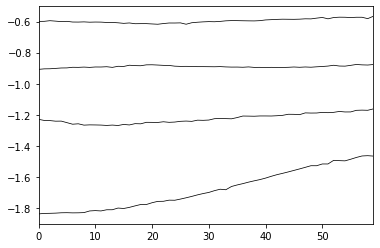

In [9]:
df.loc[0,:].T.plot(legend = None,color = 'black',linewidth = 0.75)
plt.show()

In [0]:
df = df.sort_index().values.reshape(-1,4,60).transpose(0,2,1)

In [0]:
label = to_categorical(label[0].factorize()[0])

In [12]:
print('DataFrame shape = {}'.format(df.shape))
print('Label shape = {}'.format(label.shape))

DataFrame shape = (2205, 60, 4)
Label shape = (2205, 3)


In [0]:
xtrain,xtest,ytrain,ytest = train_test_split(df,label,random_state = 42,test_size = 0.2)

In [19]:
sensor = 4
period = 60

mdl = Sequential()
mdl.add(Conv1D(100,6,activation = 'relu',input_shape = (period,sensor)))
mdl.add(Conv1D(100,6,activation = 'relu'))
mdl.add(MaxPooling1D(3))
mdl.add(Conv1D(160,6,activation = 'relu'))
mdl.add(Conv1D(160,6,activation = 'relu'))
mdl.add(GlobalAveragePooling1D())
mdl.add(Dropout(0.5))
mdl.add(Dense(3,activation = 'softmax'))

print(mdl.summary())

mdl.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 55, 100)           2500      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 100)           60100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 11, 160)           96160     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 160)            153760    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)              

In [0]:
batch = 16
epoch = 10

hist = mdl.fit(xtrain,ytrain,batch_size = batch,epochs = epoch,validation_split = 0.2,verbose = 0)

In [16]:
print(mdl.evaluate(xtest,ytest,verbose = 2))

441/441 - 0s - loss: 0.1798 - acc: 0.9796
[0.17978598431698858, 0.97959185]


In [17]:
print(classification_report(np.where(ytest != 0)[1],mdl.predict_classes(xtest)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       152
           1       0.96      0.98      0.97       135
           2       1.00      0.97      0.99       154

    accuracy                           0.98       441
   macro avg       0.98      0.98      0.98       441
weighted avg       0.98      0.98      0.98       441



In [18]:
print(confusion_matrix(np.where(ytest != 0)[1],mdl.predict_classes(xtest),normalize = 'true'))

[[0.98684211 0.01315789 0.        ]
 [0.02222222 0.97777778 0.        ]
 [0.         0.02597403 0.97402597]]
